## 1. Probabilistic models

This notebook explores the development of a spatial Random Forest model to predict the propability of access to agri-climate advisory services, using the previously processed farm dataset. The modeling is performed in incremental steps of increasing complexity:

**Basic Spatial Model:** Uses the cleaned dataset with received_climate_information as the dependent variable and only latitude and longitude as covariates.

**Expanded Farm Model:** Incorporates 100 farm points with coordinates, production, demographic, socioeconomic, and survey variables.

**Environmental-Enriched Model:** Adds satellite and gridded data (NDVI, precipitation, travel time to cities) to farm variables.

**Probability Mapping:** Applies the best-performing model to compute access probabilities across the study area using only travel time and precipitation.

The notebook demonstrates the incremental improvement of model performance as additional covariates are included and shows how spatial predictions can be extended across the landscape.

In [ ]:
# import libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.interpolate import griddata
import plotly.express as px


Load the merged and cleaned dataset

In [2]:
# Load data
df = pd.read_csv('../Data/cleaned/merged_std_all.csv')
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hhid                           100 non-null    int64  
 1   land_total_acres               100 non-null    float64
 2   land_cultivated_acres          100 non-null    float64
 3   maize_harvest_qty              100 non-null    float64
 4   maize_unit                     100 non-null    object 
 5   livestock_owned                100 non-null    object 
 6   livestock_types                100 non-null    object 
 7   usedom                         100 non-null    object 
 8   climate_info_received          100 non-null    object 
 9   hh_head_gender                 100 non-null    object 
 10  hh_size_total                  100 non-null    int64  
 11  hh_head_education              100 non-null    object 
 12  latitude                       100 non-null    floa

## Basic model

I carried out this analysis to explore the **spatial patterns of access to climate information** using only latitude and longitude as predictors. By training a spatial-only random forest model, the goal is to test whether geographical location alone can explain differences in access across the study area.


Spatial model accuracy: 0.600

Feature Importance:
     feature  importance
0   latitude    0.507591
1  longitude    0.492409


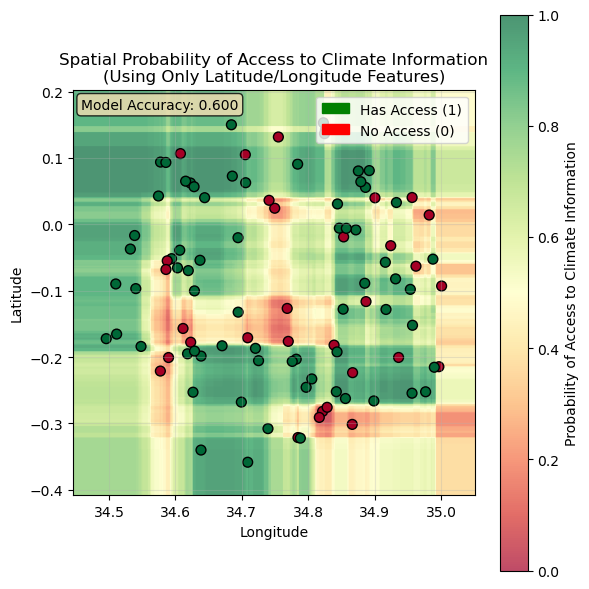

In [3]:
# Prepare the data
X = df[['latitude', 'longitude']]  # Use only spatial features
y = df['climate_info_received_num']  # Binary target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train spatial-only model
spatial_model = RandomForestClassifier(n_estimators=100, random_state=42)
spatial_model.fit(X_train, y_train)

# Evaluate the model
y_pred = spatial_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Spatial model accuracy: {accuracy:.3f}")

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': ['latitude', 'longitude'],
    'importance': spatial_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Get the bounds of data
lat_min, lat_max = df['latitude'].min()-0.05, df['latitude'].max()+0.05
lon_min, lon_max = df['longitude'].min()-0.05, df['longitude'].max()+0.05

# Define grid resolution 
grid_size = 0.001  # Smaller grid for more detail

# Create grid points
lat_grid = np.arange(lat_min, lat_max + grid_size, grid_size)
lon_grid = np.arange(lon_min, lon_max + grid_size, grid_size)

# Create a meshgrid
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Flatten to create a DataFrame of grid points
grid_points = pd.DataFrame({
    'latitude': lat_mesh.ravel(),
    'longitude': lon_mesh.ravel()
})

# Predict probabilities on the grid
grid_points['prob_access'] = spatial_model.predict_proba(grid_points)[:, 1]

# Reshape probabilities back to grid shape
prob_grid = grid_points['prob_access'].values.reshape(lon_mesh.shape)

# Create the plot
plt.figure(figsize=(6, 6))

# Plot the probability surface
im = plt.imshow(prob_grid, 
                extent=[lon_min, lon_max, lat_min, lat_max],
                origin='lower', 
                cmap='RdYlGn', 
                alpha=0.7,
                vmin=0, vmax=1)  # Ensure color scale from 0 to 1
plt.colorbar(im, label='Probability of Access to Climate Information')

# Overlay actual data points
scatter = plt.scatter(df['longitude'], df['latitude'], 
                     c=df['climate_info_received_num'], 
                     cmap='RdYlGn', 
                     s=50, 
                     edgecolors='black',
                     linewidth=1,
                     vmin=0, vmax=1)

# Add legend
import matplotlib.patches as mpatches
yes_patch = mpatches.Patch(color='green', label='Has Access (1)')
no_patch = mpatches.Patch(color='red', label='No Access (0)')
plt.legend(handles=[yes_patch, no_patch], loc='upper right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Probability of Access to Climate Information\n(Using Only Latitude/Longitude Features)')
plt.grid(True, alpha=0.3)

# Add accuracy text box
textstr = f'Model Accuracy: {accuracy:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


The resulting probability surface highlights how the likelihood of receiving climate information and agricultural advisory varies continuously across space, providing an intuitive visualization of potential geographic disparities. 

Overlaying the observed data points allows comparison between the actual distribution and the model’s predictions, while the reported accuracy gives a quantitative measure of how well spatial features explain the binary outcome. Finally, examining feature importance helps to understand whether latitude or longitude plays a stronger role in shaping these spatial differences. 

Overall, this analysis demonstrates whether geographic position is a meaningful driver of advisory access and provides a baseline against which richer models with additional socio-economic or environmental variables can be compared.

## Expanded Farm Model

This model incorporates 100 farm points with coordinates, production, demographic, socioeconomic, and survey variables. The plotted figure shows how the probabilities of access advisory are distributed across the study area.

enhanced model accuracy: 0.550

enhanced Model Feature Importance:
                         feature  importance
1                      longitude    0.233844
0                       latitude    0.203089
3           maize_yield_ton_acre    0.182492
4  orgfert_qty_2024_kg_total_std    0.156033
2          land_cultivated_acres    0.110535
5        hh_head_education_class    0.096773
6            livestock_owned_bin    0.017233


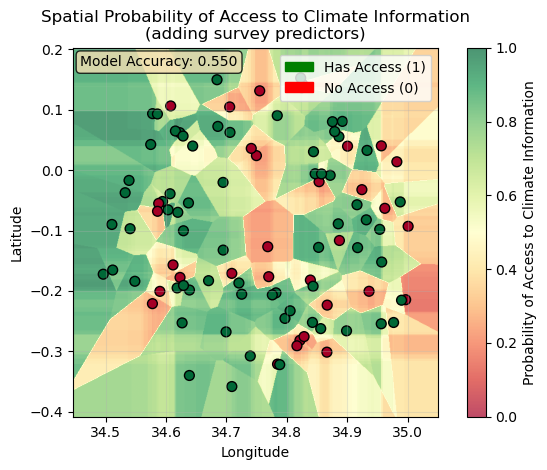

In [4]:

# Select features and target
features = ['latitude', 'longitude', 'land_cultivated_acres', 'maize_yield_ton_acre',
            'orgfert_qty_2024_kg_total_std', 'hh_head_education_class', 'livestock_owned_bin']
X_enhanced = df[features]
y = df['climate_info_received_num']

# Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)

# Train enhanced model
enhanced_model = RandomForestClassifier(n_estimators=100, random_state=42)
enhanced_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = enhanced_model.predict(X_test)
accuracy_en = accuracy_score(y_test, y_pred)
print(f"enhanced model accuracy: {accuracy_en:.3f}")

# Evaluate feature importance
feature_importance_enhanced = pd.DataFrame({
    'feature': features,
    'importance': enhanced_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nenhanced Model Feature Importance:")
print(feature_importance_enhanced)


# Create grid with interpolated values for other features
grid_points_enhanced = pd.DataFrame({
    'latitude': lat_mesh.ravel(),
    'longitude': lon_mesh.ravel()
})



# Interpolate other features across the grid
for feat in ['land_cultivated_acres', 'maize_yield_ton_acre','orgfert_qty_2024_kg_total_std', 
            'hh_head_education_class', 'livestock_owned_bin']:
    grid_points_enhanced[feat] = griddata(
        (df['longitude'], df['latitude']),
        df[feat],
        (grid_points_enhanced['longitude'], grid_points_enhanced['latitude']),
        method='nearest',
        fill_value=df[feat].median()
    )

# Predict probabilities
grid_points_enhanced['prob_access'] = enhanced_model.predict_proba(grid_points_enhanced)[:, 1]
prob_grid_enhanced = grid_points_enhanced['prob_access'].values.reshape(lon_mesh.shape)

# Plot the probability surface
im = plt.imshow(prob_grid_enhanced, 
                extent=[lon_min, lon_max, lat_min, lat_max],
                origin='lower', 
                cmap='RdYlGn', 
                alpha=0.7,
                vmin=0, vmax=1)  # Ensure color scale from 0 to 1
plt.colorbar(im, label='Probability of Access to Climate Information')

# Overlay actual data points
scatter = plt.scatter(df['longitude'], df['latitude'], 
                     c=df['climate_info_received_num'], 
                     cmap='RdYlGn', 
                     s=50, 
                     edgecolors='black',
                     linewidth=1,
                     vmin=0, vmax=1)

# Add legend
import matplotlib.patches as mpatches
yes_patch = mpatches.Patch(color='green', label='Has Access (1)')
no_patch = mpatches.Patch(color='red', label='No Access (0)')
plt.legend(handles=[yes_patch, no_patch], loc='upper right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Probability of Access to Climate Information\n(adding survey predictors)')
plt.grid(True, alpha=0.3)

# Add accuracy text box
textstr = f'Model Accuracy: {accuracy_en:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()



The enhanced model may show lower performance because the added features could introduce noise or irrelevant variation, reducing the model’s ability to generalize. Some features might be poorly measured or sparse, leading to inaccurate interpolations across the grid. Additionally, including correlated or redundant variables can confuse the model, slightly lowering predictive accuracy compared to the simpler spatial-only model.

## Environmental-Enriched Model

Load the farm data including survey data as well as additional satellite/ grid data points

In [5]:
gdf = gpd.read_file('../Data/spatial/farms.geojson')
import numpy as np

gdf. info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   hhid                           100 non-null    int32   
 1   land_total_acres               100 non-null    float64 
 2   land_cultivated_acres          100 non-null    float64 
 3   maize_harvest_qty_kg           100 non-null    float64 
 4   maize_yield_ton_acre           100 non-null    float64 
 5   orgfert_qty_2024_kg_total_std  100 non-null    float64 
 6   livestock_owned_bin            100 non-null    int32   
 7   hh_head_education_class        100 non-null    int32   
 8   climate_info_received_num      100 non-null    int32   
 9   latitude                       100 non-null    float64 
 10  longitude                      100 non-null    float64 
 11  mean_rain                      100 non-null    float64 
 12  travel_tim                   

Next, build a model using all variables available

In [6]:
# Select features and target
features_ext = ['latitude', 'longitude', 'land_cultivated_acres', 'maize_yield_ton_acre',
            'orgfert_qty_2024_kg_total_std', 'hh_head_education_class', 'livestock_owned_bin', 'mean_rain', 'travel_tim', 'ndvi']
X_full = gdf[features_ext]
y = gdf['climate_info_received_num']

# Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)

# Train full model
full_model = RandomForestClassifier(n_estimators=100, random_state=42)
full_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = full_model.predict(X_test)
accuracy_en = accuracy_score(y_test, y_pred)
print(f"Full model accuracy: {accuracy_en:.3f}")

# Evaluate feature importance
feature_importance_full = pd.DataFrame({
    'feature': features_ext,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFull Model Feature Importance:")
print(feature_importance_full)


# Create grid with interpolated values for other features
grid_points_full = pd.DataFrame({
    'latitude': lat_mesh.ravel(),
    'longitude': lon_mesh.ravel()
})

# Interpolate other features across the grid
for feat in ['land_cultivated_acres', 'maize_yield_ton_acre','orgfert_qty_2024_kg_total_std', 
            'hh_head_education_class', 'livestock_owned_bin','mean_rain', 'travel_tim', 'ndvi']:
    grid_points_full[feat] = griddata(
        (gdf['longitude'], gdf['latitude']),
        gdf[feat],
        (grid_points_full['longitude'], grid_points_full['latitude']),
        method='nearest',
        fill_value=gdf[feat].median()
    )

# Predict probabilities on the full mesh
grid_points_full['prob_access'] = full_model.predict_proba(grid_points_full[features_ext])[:, 1]



Full model accuracy: 0.550

Full Model Feature Importance:
                         feature  importance
1                      longitude    0.211441
0                       latitude    0.206959
3           maize_yield_ton_acre    0.166667
4  orgfert_qty_2024_kg_total_std    0.137911
5        hh_head_education_class    0.107785
2          land_cultivated_acres    0.094504
9                           ndvi    0.028281
6            livestock_owned_bin    0.017935
8                     travel_tim    0.017151
7                      mean_rain    0.011367


Iteratively refine the model by selecting and trimming variables to optimize performance and improve predictive accuracy.

In [7]:
# Select features and target
features_ext = ['latitude', 'longitude', 'land_cultivated_acres', 'maize_yield_ton_acre', 'orgfert_qty_2024_kg_total_std',
            'hh_head_education_class','travel_tim']
X_full = gdf[features_ext]
y = gdf['climate_info_received_num']

# Split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)

# Train full model
full_model = RandomForestClassifier(n_estimators=100, random_state=42)
full_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = full_model.predict(X_test)
accuracy_en = accuracy_score(y_test, y_pred)
print(f"Full model accuracy: {accuracy_en:.3f}")

# Evaluate feature importance
feature_importance_full = pd.DataFrame({
    'feature': features_ext,
    'importance': full_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFull Model Feature Importance:")
print(feature_importance_full)


Full model accuracy: 0.650

Full Model Feature Importance:
                         feature  importance
1                      longitude    0.224594
0                       latitude    0.201783
3           maize_yield_ton_acre    0.178766
4  orgfert_qty_2024_kg_total_std    0.158507
2          land_cultivated_acres    0.109845
5        hh_head_education_class    0.094405
6                     travel_tim    0.032101


I reduced the number of predictors following low feature importance reports. For instance NDVI data seems to affect the model performance, so I removed it.
An improved model performance is observed after this process.

## Probability Mapping

Run the resulting model on the full farm dataset to obtain farm probability of advisory access.

The interactive map below shows the calculated probability of farms accessing advisory. Each point represents a farm in the dataset.

In [8]:
gdf_prob = gdf.copy()
gdf_prob['prob_access'] = full_model.predict_proba(gdf_prob[features_ext])[:, 1]

fig = px.scatter_map(gdf_prob, 
                        lat="latitude",
                        lon="longitude",
                        #size= 'land_total_acres',
                        color="prob_access",
                        color_continuous_scale="matter",
                        range_color=[0, 1],
                        hover_data=features_ext,  # Show extra info on hover
                        title="Probability to access climate services and agricultural advisory",
                        zoom=9)

fig.update_layout(mapbox_style="satellite")
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.update_traces(marker_size=10)
fig.show()

To finalize, I apply the model on a scenario where no survey data is avaiable and only satellite (rainfall) and gridded data (trave time) are available for the entire study area.

In [9]:

# Load the grid with the mesh of Satellite variables
grid_data= gpd.read_file('../Data/spatial/grid_data_extended.geojson')

# Add columns for survey variables fill all with na
grid_data[['land_cultivated_acres', 'maize_yield_ton_acre',
            'orgfert_qty_2024_kg_total_std', 'hh_head_education_class', 'livestock_owned_bin']]= np.nan
grid_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4677 entries, 0 to 4676
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   mean_rain                      4677 non-null   float64 
 1   travel_tim                     4677 non-null   int32   
 2   ndvi                           4677 non-null   float64 
 3   longitude                      4677 non-null   float64 
 4   latitude                       4677 non-null   float64 
 5   geometry                       4677 non-null   geometry
 6   land_cultivated_acres          0 non-null      float64 
 7   maize_yield_ton_acre           0 non-null      float64 
 8   orgfert_qty_2024_kg_total_std  0 non-null      float64 
 9   hh_head_education_class        0 non-null      float64 
 10  livestock_owned_bin            0 non-null      float64 
dtypes: float64(9), geometry(1), int32(1)
memory usage: 383.8 KB


The next figure shows the trained model's capability of predicting farms probabilities of access to advisory services for the entire study area.

Index(['latitude', 'longitude', 'prob_access'], dtype='object')


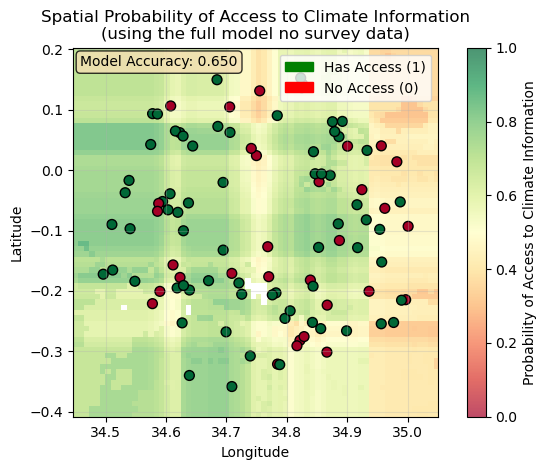

In [10]:
# Select features for prediction same as in the trained model
grid_points_full = grid_data[features_ext]
print(grid_points.columns)

# Get the number of unique latitudes and longitudes
n_lat = len(grid_points_full['latitude'].unique())
n_lon = len(grid_points_full['longitude'].unique())

# Sort by latitude and longitude to ensure correct order
grid_points_sorted = grid_points_full.sort_values(['latitude', 'longitude'])

# Predict probabilities on the sorted DataFrame
grid_points_sorted['prob_access'] = full_model.predict_proba(grid_points_sorted)[:, 1]

# Reshape the predicted probabilities into a 2D array

# Initialize with NaN
prob_grid_full = np.full((n_lat, n_lon), np.nan)

# Assign known values
lat_idx = {lat: i for i, lat in enumerate(sorted(grid_points_sorted['latitude'].unique()))}
lon_idx = {lon: j for j, lon in enumerate(sorted(grid_points_sorted['longitude'].unique()))}

for _, row in grid_points_sorted.iterrows():
    prob_grid_full[lat_idx[row['latitude']], lon_idx[row['longitude']]] = row['prob_access']

# Plot the probability surface
im = plt.imshow(prob_grid_full, 
                extent=[lon_min, lon_max, lat_min, lat_max],
                origin='lower', 
                cmap='RdYlGn', 
                alpha=0.7,
                vmin=0, vmax=1)  # Ensure color scale from 0 to 1
plt.colorbar(im, label='Probability of Access to Climate Information')

# Overlay actual data points
scatter = plt.scatter(df['longitude'], df['latitude'], 
                     c=df['climate_info_received_num'], 
                     cmap='RdYlGn', 
                     s=50, 
                     edgecolors='black',
                     linewidth=1,
                     vmin=0, vmax=1)

# Add legend
import matplotlib.patches as mpatches
yes_patch = mpatches.Patch(color='green', label='Has Access (1)')
no_patch = mpatches.Patch(color='red', label='No Access (0)')
plt.legend(handles=[yes_patch, no_patch], loc='upper right')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Probability of Access to Climate Information\n(using the full model no survey data)')
plt.grid(True, alpha=0.3)

# Add accuracy text box
textstr = f'Model Accuracy: {accuracy_en:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()


The purpose of these notebooks was to demonstrate the creation of a machine learning spatial model using survey data combined with external environmental and accessibility data. Model performance is limited due to the small number of covariates and the simplified workflow.

A robust geospatial machine learning (ML) process would typically include:

Integration of survey, environmental, socioeconomic, and infrastructure datasets.

Advanced feature engineering, including spatial interactions and derived variables.

Use of spatially-aware ML models (e.g., Random Forest, Gradient Boosting, GWR) with hyperparameter tuning.

Spatial cross-validation to account for autocorrelation and prevent overfitting.

Generation of spatial predictions and probability maps with uncertainty estimates.

Iterative evaluation and refinement based on feature importance and residual analysis.

Sensitivity analyses, such as jackknife resampling, are employed to assess the robustness and stability of model predictions.

This ensures accurate, interpretable, and spatially coherent predictions suitable for decision-making and policy applications.

Additional data visualization steps are presented in the notebook 6_data_visualization.ipynb